In [1]:
using Revise, Plots
using BifurcationKit
const BK = BifurcationKit
using LaTeXStrings
using DifferentialEquations
using Setfield

default(gridlinewidth = 2, gridalpha= 0.05, linewidth = 1.5, framestyle = :box, size = (220, 200), 
    xtickfont=font(9), ytickfont=font(9), legendfont=font(9), guidefont=font(12))

In [2]:
function fossils_hex!(dz, z, p, t)
    (; alpha0, alpha, gamma0, gamma,
       du, dv, ku, kv, kc, nu, nv, Dv,
       Nx, Ny) = p

    Ncells = Nx * Ny
    fill!(dz, 0.0)

    #reactions
    @inbounds for j in 1:Ny, i in 1:Nx
        k = (j-1)*Nx + i
        ui = z[2k-1]
        vi = z[2k]

        dz[2k-1] =
            alpha0 +
            alpha * (ui^nu) / (ku^nu + ui^nu) -
            du * ui -
            kc * ui * vi

        dz[2k] =
            gamma0 +
            gamma * (ui^nv) / (kv^nv + ui^nv) -
            dv * vi
    end

    #diffusion of v (hexagonal grid, reflecting boundary conditions)
    
    @inbounds for j in 1:Ny, i in 1:Nx
        k  = (j-1)*Nx + i
        vi = z[2k]

        acc = 0.0

        for (ii, jj) in ((i-1, j), (i+1, j))
            if 1 <= ii <= Nx && 1 <= jj <= Ny
                kk = (jj-1)*Nx + ii
                acc += z[2kk] - vi
            end
        end

        if iseven(j)
            nbrs = ((i,   j-1), (i+1, j-1),
                    (i,   j+1), (i+1, j+1))
        else
            nbrs = ((i-1, j-1), (i,   j-1),
                    (i-1, j+1), (i,   j+1))
        end

        for (ii, jj) in nbrs
            if 1 <= ii <= Nx && 1 <= jj <= Ny
                kk = (jj-1)*Nx + ii
                acc += z[2kk] - vi
            end
        end

        #hexagonal Laplacian
        dz[2k] += (2/3) * Dv * acc
    end

    return nothing
end


function FOSSILS_HEX(z, p)
    dz = similar(z)
    fossils_hex!(dz, z, p, 0.0)
    return dz
end

#grid size

Nx = 7
Ny = 7
Ncells = Nx * Ny

#model parameters
par = (
    alpha0 = 0.64,
    gamma0 = 0.1,
    alpha  = 2.0,
    gamma  = 15.,
    kc     = 1.0,
    ku     = 1.2,
    kv     = 2.0,
    nu     = 4.,
    nv     = 4.,
    du     = 1.0,
    dv     = 1.0,
    Dv     = 4.0,
    Nx     = Nx,
    Ny     = Ny
)

#initial conditions

#initial conditions of a  single-ON cell

ON_index = trunc(Int, Nx*Ny/2)  # center of grid
print(ON_index)
z_single = zeros(2*Ncells)

for k in 1:Ncells
    if k == ON_index
        z_single[2k-1] = 1.2  # u_ON
        z_single[2k] = 0.3 
    else
        z_single[2k-1] = 0.6  # u_OFF
        z_single[2k] = 0.25        # 
    end
end

#time integration

tfinal = 200
tspan = (0.0, tfinal)

prob = ODEProblem(fossils_hex!, z_single, tspan, par)
sol  = DifferentialEquations.solve(prob, Rosenbrock23())

z_ss = sol[end]


24

98-element Vector{Float64}:
 0.6169743620763497
 0.24904513085809343
 0.6143628426224199
 0.25100731647861385
 0.6120708178150354
 0.25277234447296615
 0.612514402161931
 0.2524276031871528
 0.6158229562297018
 0.2499038648144555
 0.6194668906706438
 0.24722041879237588
 0.6215932071247225
 ⋮
 0.6143628426224199
 0.25100731647861385
 0.6120708178150354
 0.25277234447296615
 0.612514402161931
 0.2524276031871528
 0.6158229562297018
 0.2499038648144555
 0.6194668906706438
 0.24722041879237588
 0.6215932071247225
 0.24570054376808428

┌ Warning: To maintain consistency with solution indexing, keyword argument vars will be removed in a future version. Please use keyword argument idxs instead.
│   caller = ip:0x0
└ @ Core :-1


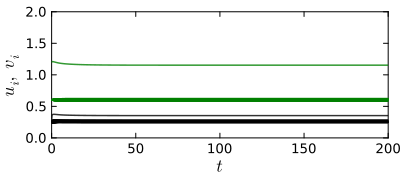

"/Users/jmercadal/Desktop/Simulations/fossil_oil_bodies/dynamics_hexagonal.pdf"

In [3]:
plt = plot()

for i in 1:Nx*Ny
    plot!(plt, sol, vars=(2i-1),
          label=false, color=:green, alpha=0.8, linestyle=:solid)
    plot!(plt, sol, vars=(2i),
          label=false, color=:black, alpha=0.8, linestyle=:solid, xlims=(0.,tfinal), ylims=(0.,2),legend=false, grid = false,
          background_color=:transparent, size = (400,175))
end

xlabel!(plt, L"t")
ylabel!(plt, L"u_i,\; v_i")
display(plt)

savefig("dynamics_hexagonal.pdf")


In [4]:
#record function for all u_i
recordCO(x, p; kwargs...) = (
    ; [Symbol("u$i") => x[2i-1] for i in 1:Ncells]...
)

#continuation options
opts = ContinuationPar(
    dsmin = 1e-8, ds = -1e-6, dsmax = 1e-4,
    p_min = 0.01, p_max = 1.25,
    max_steps = 400
)

#bifurcation problem
probBK = BifurcationProblem(
    FOSSILS_HEX,
    z_single,
    par,
    IndexLens(1);                # continuation in alpha0
    record_from_solution = recordCO
)

br = continuation(probBK, PALC(), opts; normC = norminf)

br

 ┌─ Curve type: EquilibriumCont
 ├─ Number of points: 401
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter p1 starts at 0.64, ends at 0.6643962795242614
 ├─ Algo: PALC [Secant]
 └─ Special points:

- #  1,       bp at p1 ≈ +0.63305749 ∈ (+0.63305746, +0.63305749), |δp|=3e-08, [converged], δ = ( 1,  0), step =  84
- #  2, endpoint at p1 ≈ +0.66449792,                                                                     step = 401


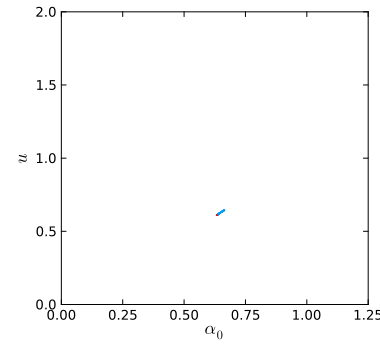

"/Users/jmercadal/Desktop/Simulations/fossil_oil_bodies/bif_diagram_1cell.pdf"

In [5]:
plt = plot()
plot!(plt, br,
        xlims = (0.0, 1.25),
        ylims = (0.0, 2.0),
        xlabel = L"$\alpha_0$",
        ylabel = L"$u$",
        markercolors = :red,
        markersize = 1.0,
        background_color = :transparent,
        linewidthstable = 1.5,
        linewidthunstable = 1.5,
        grid = false,
        label = false,
        size = (380, 360))

display(plt)

savefig("bif_diagram_1cell.pdf")


In [ ]:
bif_par2 = IndexLens(4)  # codimension 2 parameter, gamma

pmin = 0.01
pmax = 18.0

opts_codim2 = ContinuationPar(
    dsmin = 1e-3,
    ds = 1e-2,
    dsmax = 0.05,
    p_min = pmin,
    p_max = pmax,
    max_steps = 1000
)
sn_indices = [
    i for (i, sp) in enumerate(br.specialpoint[1:end-1])
    if sp !== nothing && sp.type == :bp
]

println("Detected bifurcation points at indices: ", sn_indices)

sn_branches_all = []

for idx in sn_indices
    println("Continuing codim-2 branch from bifurcation index $idx")

    sn_branch = continuation(
        br,
        idx,
        bif_par2,
        opts_codim2;
        normC = norminf,
        bothside = true,
        detect_codim2_bifurcation = 2
    )

    push!(sn_branches_all, sn_branch)
end

sn_branches_all

Detected bifurcation points at indices: 

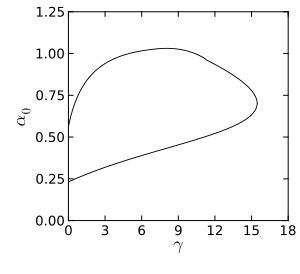

"/Users/jmercadal/Desktop/Simulations/fossil_oil_bodies/cod2_hexagonal_1cell.pdf"

In [493]:
plt = plot()
for sn_br in sn_branches_all
    plot!(sn_br, xlims=(0.,18), ylims=(0.,1.25),legend=false, grid = false, color = :black,  linewidth = 0.9,
     xlabel = L"$\gamma$", ylabel = L"$\alpha_0$", markersize = 0, background_color=:transparent, size = (300,275))
end

display(plt)

savefig("cod2_hexagonal_1cell.svg")
savefig("cod2_hexagonal_1cell.pdf")